# Review Helpfulness Classification - DL Models
* Model Baselines - Dual-CNN, Bi-LSTM, Bi-GRU, BERT
* Dataset - Amazon(Toys and Games, CDs and Vinyls)


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.6 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, LSTM, Embedding, Dropout, Dense, Flatten, Bidirectional, Conv1D, GlobalMaxPool1D, Input, concatenate, MaxPooling1D, GlobalMaxPooling1D, MaxPool1D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import relu, sigmoid
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
import random
import nltk
import json
import tqdm
import re, os

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
amzn = pd.read_csv('/datasets/preprocessed_amazon_CDs_and_Vinyl.csv')
print(amzn.shape)
amzn.head()

<ipython-input-2-f2ae8850df71>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  amzn = pd.read_csv('/content/drive/MyDrive/seminar/bert_review_helpfulness/datasets/datasets/preprocessed_amazon_CDs_and_Vinyl.csv')


(980226, 7)


,asin,reviewerID,overall,reviewText,vote,helpfulness label,Cleaned_Review_Text
0,B000003BDJ,A14PEJXDFAFIXJ,5,I picked this up to see how well the new remas...,11,1,pick see well new remastering sound stone rema...
1,B000002J4B,A1J5KCZC8CMW9I,4,"I hesitate to say this is their best album, bu...",5,1,hesitate say best album definitely popular one...
2,B0000070I6,A1RJ8DR9MBFY8P,4,The band presents a harder edge in this third ...,3,1,band present harder edge third release vocalis...
3,B001EOQUF0,A19YHEBK099R7U,5,TV On The Radio - Dear Science (2008)\n\nSimpl...,3,1,radio dear science simply put album brilliant ...
4,B0009IW9A2,A1MHUYZLFVQGNA,5,"This cd is not just music, but an experience. ...",3,1,music experience group years time understand f...


## 1) Text Preprocessing
* 모델 투입 전 텍스트 전처리 수행

In [ ]:
def sampling(sample_size, df=None):
  '''
  sample_size만큼 helpful_df & unhelpful_df에서 데이터 샘플 추출
  전체 추출되는 Data Size = 2 * sample_size
  '''
  helpful_df = df[df['helpfulness label'] == 1]
  unhelpful_df = df[df['helpfulness label'] == 0]
  helpful_samples = helpful_df.sample(n=sample_size, random_state=42)
  unhelpful_samples = unhelpful_df.sample(n=sample_size, random_state=42)

  df_samples = pd.concat([helpful_samples, unhelpful_samples])
  return df_samples

amzn = sampling(490113, amzn)

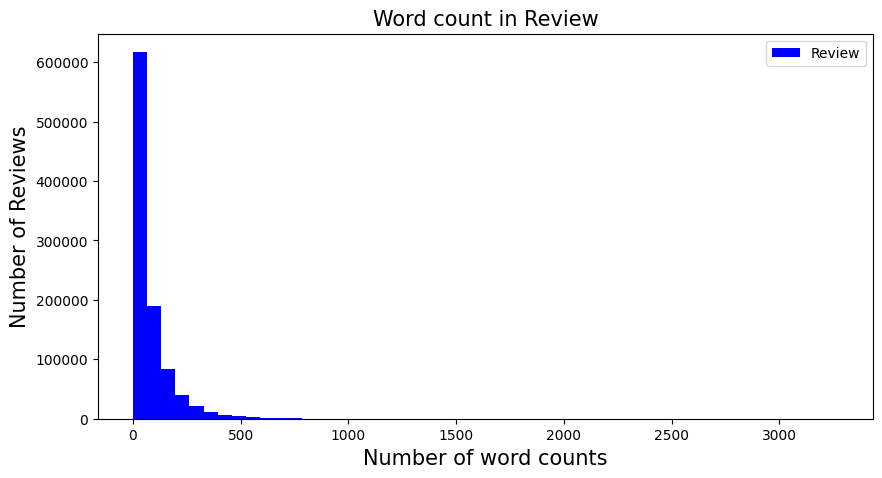

리뷰 단어 개수 최댓값 : 3271
리뷰 단어 개수 최소값 : 1
리뷰 단어 개수 평균값 : 75.32834876854929
리뷰 단어 개수 상위 90%값 : 120.0


In [ ]:
# Preprocessing for DL Models
def check_word_count(df=None):
  train_word_count = df['Cleaned_Review_Text'].apply(lambda x: len(str(x).split(' ')))

  plt.figure(figsize=(10,5))
  plt.hist(train_word_count, bins=50, color='b', label='Review')
  plt.title('Word count in Review',fontsize=15)
  plt.legend()
  plt.xlabel('Number of word counts', fontsize=15)
  plt.ylabel('Number of Reviews', fontsize=15)
  plt.show()


  print(f'리뷰 단어 개수 최댓값 : {np.max(train_word_count)}')
  print(f'리뷰 단어 개수 최소값 : {np.min(train_word_count)}')
  print(f'리뷰 단어 개수 평균값 : {np.mean(train_word_count)}')
  print(f'리뷰 단어 개수 상위 90%값 : {np.percentile(train_word_count, 80)}')

check_word_count(amzn)

In [ ]:
tokenizer = Tokenizer()
max_len = 512

def tokenizing(tokenizer,df=None):
  '''
  전처리 완료된 processed_text를 불러와
  토큰화 및 각 토큰에 대해 정수 인코딩
  padding처리 된 부분 --> <PAD> 토큰 부여 및 0으로 값 지정
  '''
  train_review = df['Cleaned_Review_Text'].astype(str)
  tokenizer.fit_on_texts(train_review)
  text_sequences = tokenizer.texts_to_sequences(train_review)

  word_vocab = tokenizer.word_index
  word_vocab['<PAD>'] = 0

  return text_sequences, word_vocab


def text_padding(max_len,df=None):
  '''
  text sequence의 길이 통일
  '''
  text_sequences, word_vocab = tokenizing(tokenizer,df)
  text_inputs = pad_sequences(text_sequences, maxlen=max_len, padding='post')
  print(f'shape of train_data : {text_inputs.shape}')

  return text_inputs, word_vocab


text_inputs, word_vocab = text_padding(max_len, amzn)

shape of train_data : (980226, 512)


In [ ]:
data_configs = dict()
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

np.save(open('amzn_text_512.npy','wb'), text_inputs)
np.save(open('amzn_label_512.npy','wb'), np.array(amzn['helpfulness label']))
json.dump(data_configs, open('amzn_configs_512.json','w'),ensure_ascii=False)

In [ ]:
# Data Splitting

inputs = np.load(open('/content/drive/MyDrive/seminar/bert_review_helpfulness/datasets/dl_text_inputs/amzn_text_512.npy','rb'))
labels = np.load(open('/content/drive/MyDrive/seminar/bert_review_helpfulness/datasets/dl_text_inputs/amzn_label_512.npy','rb'))
amzn_configs = json.load(open('/content/drive/MyDrive/seminar/bert_review_helpfulness/datasets/dl_text_inputs/amzn_configs_512.json','r'))

def split_data(inputs, labels, test_size):

  X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=test_size, shuffle=True, random_state=42, stratify=labels)

  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(inputs, labels, 0.2)
print(f'X_train 크기 : {len(X_train)}','\t',f'X_test 크기 : {len(X_test)}','\n')

X_train 크기 : 784180 	 X_test 크기 : 196046 



In [ ]:
# Set Seed
# numpy와 tensorflow 2가지에 seed 설정
# 해당 코드 출처 : https://dacon.io/codeshare/2363

def seed_everything(seed: int=42):
  random.seed(seed)
  np.random.seed(seed)
  os.environ['PYTHONASHSEED'] = str(seed)
  tf.random.set_seed(seed)
my_seed = 42
seed_everything(my_seed)

In [ ]:
# metrics 추가 --> Precision, Recall, F1-Score

def recall_m(y_true, y_pred):
  '''
  y_true_yn / y_pred_yn --> 실제값 또는 예측값을 1 또는 0으로 설정
  count_tp --> 실제값과 예측값이 모두 1인 경우(tp)
  count_tp_fn --> 실제 값이 1인 전체(tp+fn)
  K.epsilon --> count_tp_fn의 값이 0인 경우 대비 매우 작은 수를 더함
  '''
  y_true_yn = K.round(K.clip(y_true, 0, 1))
  y_pred_yn = K.round(K.clip(y_pred, 0, 1))

  count_tp = K.sum(y_true_yn * y_pred_yn)
  count_tp_fn = K.sum(y_true_yn)

  recall = count_tp / (count_tp_fn + K.epsilon())

  return recall


def precision_m(y_true, y_pred):
  '''
  count_tp --> 실제값과 예측값이 모두 1인 경우(tp)
  count_tp_fp --> 예측값을 1로 한 경우(tp+fp)
  '''
  y_true_yn = K.round(K.clip(y_true, 0, 1))
  y_pred_yn = K.round(K.clip(y_pred, 0, 1))

  count_tp = K.sum(y_true_yn * y_pred_yn)
  count_tp_fp = K.sum(y_pred_yn)

  precision = count_tp / (count_tp_fp + K.epsilon())

  return precision

def f1_m(y_true, y_pred):
  recall = recall_m(y_true, y_pred)
  precision = precision_m(y_true, y_pred)
  f1_score = (2 * recall * precision) / (recall + precision + K.epsilon())
  return f1_score

## 2) Baselines - Dual-CNN

In [ ]:
# Dual-CNN Prediction

kargs = {'model_name' : 'dual_cnn', 'vocab_size' : amzn_configs['vocab_size'], 'embed_dim' : 100,
         'dropout_rate' : 0.2, 'num_filters' : 100, 'kernel_size_1' : 2, 'kernel_size_2' : 3, 'kernel_size_3' : 4,
         'dense_dim_1' : 64, 'output_dim' : 1}

def cnn_1d(**kargs):
    inputs = Input(shape=(512,))

    embed = Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embed_dim'], embeddings_regularizer=l2(0), name='embed_layer')(inputs)
    conv1 = tf.keras.layers.Conv1D(filters=kargs['num_filters'], kernel_size=kargs['kernel_size_1'], padding='same',
                              activation='relu', name='cnn_layer_1')(embed)
    conv2 = tf.keras.layers.Conv1D(filters=kargs['num_filters'], kernel_size=kargs['kernel_size_2'], padding='same',
                              activation='relu', name='cnn_layer_2')(embed)
    conv3 = tf.keras.layers.Conv1D(filters=kargs['num_filters'], kernel_size=kargs['kernel_size_3'], padding='same',
                              activation='relu', name='cnn_layer_3')(embed)

    conv = concatenate([conv1, conv2, conv3], axis=-1, name='concat_conv')
    conv = Conv1D(filters=kargs['num_filters'], kernel_size=kargs['kernel_size_1'], padding='same',
                  activation='relu', name='final_conv')(conv)
    pool = GlobalMaxPool1D(name='pool')(conv)

    dense = Dense(kargs['dense_dim_1'], activation='relu', name='dense')(pool)

    output = Dense(kargs['output_dim'], activation='sigmoid', name='output')(dense)
    return Model(inputs=inputs, outputs=output)

model_cnn = cnn_1d(**kargs, name='dual-CNN')
model_cnn.compile(optimizer=Adam(learning_rate=0.007), loss='binary_crossentropy', metrics=['acc'])
model_cnn.summary()
result = model_cnn.fit(X_train, y_train, batch_size=512, epochs=500, validation_split=0.2)

In [ ]:
# 모델 결과에 대해 시각화
def draw_plot(history,metric):
  plt.figure(figsize=(7,7))
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.title('Train / Valid Accuracy',fontsize=15)
  plt.ylabel(metric)
  plt.xlabel('Epochs')
  plt.legend([metric, 'val_'+metric])
  plt.show()

draw_plot(result, 'acc')

f1_score_list = []
precision_list = []
recall_list = []

y_pred = model_cnn.predict(X_test)
idx = 0

for k in y_pred:
  if k >= 0.5:
    y_pred[idx] = 1
  else:
    y_pred[idx] = 0
  idx += 1

f1_score_list.append(f1_score(y_test, y_pred))
precision_list.append(precision_score(y_test, y_pred))
recall_list.append(recall_score(y_test, y_pred))

print(model_cnn.evaluate(X_test, y_test, batch_size=512))
print(f1_score_list)
print(precision_list)
print(recall_list)

## 3) Baselines - Bi-LSTM

In [ ]:
kargs = {'model_name' : '1d_cnn', 'vocab_size' : amzn_configs['vocab_size'], 'embed_dim' : 100,
         'dropout_rate' : 0.09, 'lstm_dim' : 64,  'dense_dim_1' : 32, 'output_dim' : 1}

def bilstm(**kargs):

    inputs = Input(shape=(512,))

    embed = Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embed_dim'], embeddings_regularizer=l2(0), name='embed_layer', mask_zero=True)(inputs)

    lstm = Bidirectional(LSTM(kargs['lstm_dim']))(embed)
    drop = Dropout(kargs['dropout_rate'], name='dropout')(lstm)
    dense_1 = Dense(64, activation='relu', name='dense')(drop)
    output = Dense(1, activation='sigmoid', name='output')(dense_1)
    return Model(inputs=inputs, outputs=output)

model_lstm = bilstm(**kargs, name='BiLSTM')
model_lstm.summary()
model_lstm.compile(optimizer=Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=['acc']) # f1_m, precision_m, recall_m
result = model_lstm.fit(X_train, y_train, batch_size=512, epochs=300, validation_split=0.2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 embed_layer (Embedding)     (None, 512, 100)          13861600  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                             

In [ ]:
f1_score_list = []
precision_list = []
recall_list = []

y_pred = model_lstm.predict(X_test)
idx = 0

for k in y_pred:
  if k >= 0.5:
    y_pred[idx] = 1
  else:
    y_pred[idx] = 0
  idx += 1

f1_score_list.append(f1_score(y_test, y_pred))
precision_list.append(precision_score(y_test, y_pred))
recall_list.append(recall_score(y_test, y_pred))

## 4) Baselines - Bi-GRU

In [ ]:
# Bi-GRU Prediction

kargs = {'model_name' : 'bi_gru', 'vocab_size' : amzn_configs['vocab_size'], 'embed_dim' : 300,
         'dropout_rate' : 0.09, 'gru_dim' : 128, 'dense_dim_1' : 64, 'output_dim' : 1}

def bi_gru(**kargs):
    inputs = Input(shape=(512,))

    embed = Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embed_dim'], embeddings_regularizer=l2(0), name='embed_layer', mask_zero=True)(inputs)
    spatial_dropout = SpatialDropout1D(0.5)(embed)
    gru = GRU(kargs['gru_dim'], name='gru')(spatial_dropout)
    dropout = Dropout(kargs['dropout_rate'], name='dropout')(gru)
    dense = Dense(kargs['dense_dim_1'], activation='relu', name='dense')(dropout)
    output = Dense(kargs['output_dim'], activation='sigmoid', name='output')(dense)
    return Model(inputs=inputs, outputs=output)

model_gru = bi_gru(**kargs, name='bi_gru')
model_gru.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['acc'])
es = EarlyStopping(patience=10, monitor='val_loss', min_delta=0.0001)
cp = ModelCheckpoint('gru_weights.h5', verbose=1, monitor='val_loss', save_best_only=True, save_weights_only=True)
model_gru.summary()
result = model_gru.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[es,cp])

In [ ]:
# 모델 결과에 대해 시각화
f1_score_list = []
precision_list = []
recall_list = []

y_pred = model_gru.predict(X_test)
idx = 0

for k in y_pred:
  if k >= 0.5:
    y_pred[idx] = 1
  else:
    y_pred[idx] = 0
  idx += 1

f1_score_list.append(f1_score(y_test, y_pred))
precision_list.append(precision_score(y_test, y_pred))
recall_list.append(recall_score(y_test, y_pred))

print(f1_score_list)
print(precision_list)
print(recall_list)

## 5) Baselines - BERT
* BERT용 전처리 및 모델 학습&예측까지 과정을 포함

In [ ]:
# Preprocessing for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir='bert_ckpt', do_lower_case=False)

def bert_tokenizer(sent, max_len):
  '''
  encode_plus를 통해 문장을 변환
  1. 문장 tokenizing
  2. add_special_tokens = True --> 토큰의 시작점에 ['CLS'] 토큰을, 토큰의 마지막에 ['SEP'] 토큰을 붙임
  3. 각 토큰을 인덱스로 변환
  4. max_length --> 문장 길이 통일, pad_to_max_length --> 패딩 적용
  5. return_attention_mask --> 어텐션 마스크 생성
  6. truncation=True --> 토큰 타입은 문장이 1개인 경우 0으로, 문장이 2개인 경우 0 및 1로 구분하여 생성
  '''
  encoded_dict = tokenizer.encode_plus(
                                       text = sent, add_special_tokens = True, max_length = max_len, pad_to_max_length = True,
                                       return_attention_mask = True, truncation=True
                                      )

  input_id = encoded_dict['input_ids']
  attention_mask = encoded_dict['attention_mask']
  token_type_id = encoded_dict['token_type_ids']

  return input_id, attention_mask, token_type_id

def clean_text(sent):
  sent_clean = re.sub('[^a-zA-Z0-9]', ' ',sent)
  return sent_clean

In [ ]:
amzn_train, amzn_test = train_test_split(amzn, test_size=0.2, shuffle=True, random_state=42, stratify=amzn['helpfulness label'])
input_ids, attention_masks = [], []
token_type_ids, data_labels = [], []

for amzn_sent, amzn_label in tqdm.tqdm(zip(amzn_train['Cleaned_Review_Text'].astype(str), amzn_train['helpfulness label']), total=len(amzn_train)):    # amzn_train['Review_Text']
  try:
    input_id, attention_mask, token_type_id = bert_tokenizer(amzn_sent, 512)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    data_labels.append(amzn_label)

  except Exception as e:
    print(e)
    print(amzn_sent)
    pass

amzn_train_input_ids = np.array(input_ids, dtype=int)
amzn_train_attention_masks = np.array(attention_masks, dtype=int)
amzn_train_type_ids = np.array(token_type_ids, dtype=int)
amzn_train_inputs = (amzn_train_input_ids, amzn_train_attention_masks, amzn_train_type_ids)
amzn_train_labels = np.asarray(data_labels, dtype=np.int32)

print(f"# sents: {len(amzn_train_input_ids)}, # labels: {len(amzn_train_labels)}")

np.save(open('amzn_bert_train_input_ids_512.npy','wb'), amzn_train_input_ids)
np.save(open('amzn_bert_train_attention_masks_512.npy','wb'), amzn_train_attention_masks)
np.save(open('amzn_bert_train_type_ids_512.npy', 'wb'), amzn_train_type_ids)
np.save(open('amzn_bert_train_label_512.npy','wb'), np.array(amzn_train['helpfulness label']))

  0%|          | 0/784180 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 784180/784180 [21:31<00:00, 607.27it/s]


# sents: 784180, # labels: 784180


In [ ]:
# bert_tokenizer - 샘플 출력
input_id_random = amzn_train_input_ids[1]
attention_mask_random = amzn_train_attention_masks[1]
token_type_id_random = amzn_train_type_ids[1]

print(input_id_random)
print(attention_mask_random)
print(token_type_id_random)
print(tokenizer.decode(input_id_random))

In [ ]:
amzn_train_input_ids = np.load(open('/datasets/bert_inputs/amzn_4over_cleaned_bert_train_input_ids_512.npy','rb'))
amzn_train_attention_masks = np.load(open('/datasets/bert_inputs/amzn_4over_cleaned_bert_train_attention_masks_512.npy','rb'))
amzn_train_type_ids = np.load(open('/datasets/bert_inputs/amzn_4over_cleaned_bert_train_type_ids_512.npy','rb'))
amzn_train_labels = np.load(open('/datasets/bert_inputs/amzn_4over_cleaned_bert_train_label_512.npy','rb'))

amzn_train_inputs = (amzn_train_input_ids, amzn_train_attention_masks, amzn_train_type_ids)

In [ ]:
# TPU 작동을 위한 셋업
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [ ]:
class bert_uncased(tf.keras.Model):

  def __init__(self, model_name, dir_path, num_class):
    super(bert_uncased, self).__init__()
    self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
    self.dropout = Dropout(self.bert.config.hidden_dropout_prob)
    self.clf = Dense(num_class,
                     activation='sigmoid',
                     name='classifier')

  def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
    '''
    bert layer 거친 후 outputs:
                              sequence_output, pooled_output, (hidden_states), (attentions)

    bert.config : bert의 구성을 저장하는 클래스
    매개변수 :
            1) vocab_size : BERT 모델의 단어사전 크기(기본 : 30522)
            2) hidden_size : 인코더 및 풀링층의 차원 크기(기본 : 768)
            3) num_hidden_layers : Transformer 인코더의 hidden_layer 개수(기본 : 12)
            4) num_attention_heads : Transformer 인코더의 각 어텐션 레이어 헤드 개수(기본 : 12)
            5) medium_size : Transformer 인코더의 FFNN층 차원(기본: 3072)
            6) hidden_act : 인코더 및 풀링층의 비선형 활성화 함수(기본 : gelu)
            7) hidden_dropout_prob : 임베딩, 인코더 및 풀링층의 완전연결층에 대한 드롭아웃 비중(기본 : 0.1)
            8) attention_probs_dropout_prob : 어텐션 과정의 드롭아웃 비중(기본 : 0.1)
            9) max_position_embeddings : 모델이 받을 수 있는 최대 시퀀스 길이(기본: 512) --> 1024, 2048등의 길이로도 변경 가능
            10) initializer_range : 모든 가중치 행렬을 초기화하는 Truncated_normal_initializer의 표준 편차(기본 : 0.02)
            11) layer_norm_eps : LN에서 사용하는 엡실론 값(기본 : 1e-12)
            12) gradient_checkpointing : True인 경우, Gradient checkpoint를 사용하여 더 느린 역전파 사용대신 메모리를 절약(기본 : False)
    '''
    outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
    pooled_output = outputs[1]
    pooled_output = self.dropout(pooled_output, training=training)
    output = self.clf(pooled_output)
    return output

In [ ]:
with strategy.scope():
  cls_model = bert_uncased(model_name='bert-base-uncased', dir_path='bert_ckpt', num_class=1)
  optimizer = Adam(1e-5)
  loss = tf.keras.losses.BinaryCrossentropy()
  metric = tf.keras.metrics.BinaryAccuracy()
  cls_model.compile(optimizer=optimizer,
                    loss=loss, metrics=[metric])
  es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)
  cp = ModelCheckpoint('bert_baseline.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
result = cls_model.fit(amzn_train_inputs, amzn_train_labels, epochs=4, batch_size=32, validation_split=0.2, callbacks=[es,cp])

Epoch 1/4
19605/19605 [==============================] - ETA: 0s - loss: 0.4897 - binary_accuracy: 0.7609
Epoch 1: val_loss improved from inf to 0.48331, saving model to bert_baseline.h5
19605/19605 [==============================] - 3597s 179ms/step - loss: 0.4897 - binary_accuracy: 0.7609 - val_loss: 0.4833 - val_binary_accuracy: 0.7686
Epoch 2/4
19605/19605 [==============================] - ETA: 0s - loss: 0.4713 - binary_accuracy: 0.7729
Epoch 2: val_loss improved from 0.48331 to 0.48027, saving model to bert_baseline.h5
19605/19605 [==============================] - 3438s 175ms/step - loss: 0.4713 - binary_accuracy: 0.7729 - val_loss: 0.4803 - val_binary_accuracy: 0.7689
Epoch 3/4
19605/19605 [==============================] - ETA: 0s - loss: 0.4448 - binary_accuracy: 0.7898
Epoch 3: val_loss did not improve from 0.48027
19605/19605 [==============================] - 3433s 175ms/step - loss: 0.4448 - binary_accuracy: 0.7898 - val_loss: 0.4955 - val_binary_accuracy: 0.7599
Epoch 4

In [ ]:
amzn_train, amzn_test = train_test_split(amzn, test_size=0.2, shuffle=True, random_state=42, stratify=amzn['helpfulness label'])
input_ids, attention_masks = [], []
token_type_ids, data_labels = [], []

for amzn_sent, amzn_label in tqdm.tqdm(zip(amzn_test['Cleaned_Review_Text'].astype(str), amzn_test['helpfulness label']), total=len(amzn_test)):   # amzn_test['Review_Text']
  try:
    input_id, attention_mask, token_type_id = bert_tokenizer(amzn_sent, 512)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    data_labels.append(amzn_label)

  except Exception as e:
    print(e)
    print(amzn_sent)
    pass

amzn_test_input_ids = np.array(input_ids, dtype=int)
amzn_test_attention_masks = np.array(attention_masks, dtype=int)
amzn_test_type_ids = np.array(token_type_ids, dtype=int)
amzn_test_inputs = (amzn_test_input_ids, amzn_test_attention_masks, amzn_test_type_ids)
amzn_test_labels = np.array(data_labels, dtype=np.int32)

print(f"# sents: {len(amzn_test_input_ids)}, # labels: {len(amzn_test_labels)}")

np.save(open('amzn_bert_test_input_ids_512.npy','wb'), amzn_test_input_ids)
np.save(open('amzn_bert_test_attention_masks_512.npy','wb'), amzn_test_attention_masks)
np.save(open('amzn_bert_test_type_ids_512.npy', 'wb'), amzn_test_type_ids)
np.save(open('amzn_bert_test_label_512.npy','wb'), amzn_test_labels)

  0%|          | 0/196046 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 196046/196046 [05:16<00:00, 618.70it/s]


# sents: 196046, # labels: 196046


In [ ]:
amzn_test_input_ids = np.load(open('/datasets/bert_inputs/amzn_4over_cleaned_bert_test_input_ids_512.npy','rb'))
amzn_test_attention_masks = np.load(open('/datasets/bert_inputs/amzn_4over_cleaned_bert_test_attention_masks_512.npy','rb'))
amzn_test_type_ids = np.load(open('/datasets/bert_inputs/amzn_4over_cleaned_bert_test_type_ids_512.npy','rb'))
amzn_test_labels = np.load(open('/datasets/bert_inputs/amzn_4over_cleaned_bert_test_label_512.npy','rb'))

amzn_test_inputs = (amzn_test_input_ids, amzn_test_attention_masks, amzn_test_type_ids)

In [ ]:
f1_score_list = []
precision_list = []
recall_list = []


y_pred = cls_model.predict(amzn_test_inputs)
idx = 0

for k in y_pred:
  if k >= 0.5:
    y_pred[idx] = 1
  else:
    y_pred[idx] = 0
  idx += 1

f1_score_list.append(f1_score(amzn_test_labels, y_pred))
precision_list.append(precision_score(amzn_test_labels, y_pred))
recall_list.append(recall_score(amzn_test_labels, y_pred))

print(f1_score_list)
print(precision_list)
print(recall_list)

[0.7594473547406726]
[0.7445238305254183]
[0.7749813819205696]
